In [9]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import yfinance as yf
import time
from tqdm import tqdm
import seaborn as sns #not needed to run program
import matplotlib.pyplot as plt #not needed to run program
import datetime
#import copy
import logging
from pypfopt import risk_models, expected_returns, EfficientFrontier, objective_functions #, plotting

In [10]:
logging.basicConfig(format = '%(asctime)s:%(levelname)s :%(message)s',
                        datefmt = '%Y-%m-%d %H:%M:%S',
                        filename = 'logs/run_main.log',
                        level=logging.INFO)

**1. Get current DAX constituents from wikipedia**

In [11]:
def replace_by_freq(dataframe, column_name, threshold, new_value):

    """
    Replace values in a column of a DataFrame based on their frequency count.

    Args:
        dataframe (pandas.DataFrame): The DataFrame to modify.
        column_name (str): The name of the column to replace values in.
        threshold (int): The frequency threshold. Values appearing less than this threshold will be replaced.
        new_value: The new value to replace the infrequent values with.

    Returns:
        pandas.DataFrame: The modified DataFrame with values replaced.

    Raises:
        KeyError: If the specified column is not found in the DataFrame.
        
    """

    try:
        unique = dataframe.groupby(column_name)[column_name].transform('size').lt(threshold)
        dataframe.loc[unique, column_name] = new_value
    except KeyError as ke:
        print(f'Column ', ke, 'is not found in a dataframe')
    
    return dataframe

In [12]:
def dax40_latest_constituents():
    
    """
    Retrieve the latest constituents of the DAX40 index from Wikipedia (https://en.wikipedia.org/wiki/DAX).

     Args:
       None

    Returns:
        pandas.DataFrame: DataFrame containing the latest DAX40 constituents.

    Raises:
        Exception: If the website URL is unreachable or does not exist.
        Exception: If the 'constituents' table cannot be found on the website.
        Exception: If there is an error while extracting columns from the table.
        KeyError: If there is an issue with the column index of the 'constituents' table.

    """

    url = 'https://en.wikipedia.org/wiki/DAX'
    response = requests.get(url, verify = False)

    #Check if the connection is succesful
    try:
        response = requests.get(url, verify = False)
        if response.ok:
            soup = BeautifulSoup(response.text, 'html.parser')
        else:
            raise Exception(f'Cannot reach website {url}')
    except:
        raise Exception(f'Website {url} does not exist')

    #check if table 'constituents' exists
    wiki_table_id = 'constituents'
    try:
        indiatable = soup.find('table',{'id': wiki_table_id,'class':'wikitable'})
        df = pd.read_html(str(indiatable))
    except:
        raise Exception(f'Table {wiki_table_id} cannot be found in {url}')

    #Extract columns from table
    extract_cols = ['Ticker', 'Company', 'Prime Standard Sector']
    try:
        dax_constituents = pd.DataFrame(df[0])[extract_cols]
        dax_constituents = dax_constituents.rename(columns = {'Prime Standard Sector': 'Sector', 'Company': 'Name'})
    except KeyError as e:
        raise Exception((e.args[0]).replace('index', 'column index of table constituents'))

    dax_constituents = replace_by_freq(dax_constituents, 'Sector', 2, 'Other')

    logging.info(f'DAX40 constituents loaded successfully')

    return dax_constituents

In [13]:
# #Test
dax_comp = dax40_latest_constituents()
# print(dax_comp.head(20))

c:\Users\48512\anaconda3\lib\site-packages\urllib3\connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'en.wikipedia.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
c:\Users\48512\anaconda3\lib\site-packages\urllib3\connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'en.wikipedia.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


<AxesSubplot:xlabel='Sector'>

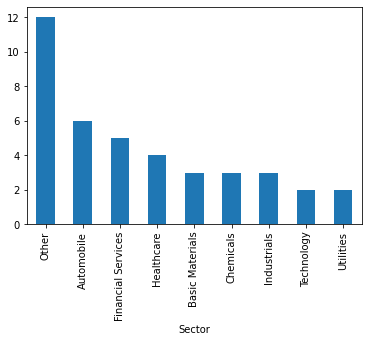

In [14]:
dax_comp.groupby(['Sector'])['Sector'].count().sort_values(ascending=False).plot.bar()

In [15]:
dax_comp.head(5)

,Ticker,Name,Sector
0,ADS.DE,Adidas,Other
1,AIR.DE,Airbus,Other
2,ALV.DE,Allianz,Financial Services
3,BAS.DE,BASF,Basic Materials
4,BAYN.DE,Bayer,Healthcare


In [16]:
def column_to_list_from_df(df, column_name):

    """
    Retrieve the values from a specific column in a DataFrame and convert them to a list.

    Args:
        df (pandas.DataFrame): The DataFrame containing the desired column.
        column_name (str): The name of the column to extract values from.

    Returns:
        list: A list containing the values from the specified column.

    Raises:
        KeyError: If the specified column does not exist in the DataFrame.
        Exception: If an error occurs while retrieving the column values.
        
    """

    try:
        output = df[column_name].values.tolist()
        return output
    except KeyError:
        raise KeyError(f"Column '{column_name}' does not exist in the DataFrame.")
    except:
        raise Exception("An error occurred while retrieving the column values.")


In [17]:
#A list of tickers from contituents
dax_tickers = column_to_list_from_df(dax_comp, 'Ticker')

In [18]:
print(dax_tickers)

['ADS.DE', 'AIR.DE', 'ALV.DE', 'BAS.DE', 'BAYN.DE', 'BEI.DE', 'BMW.DE', 'BNR.DE', 'CBK.DE', 'CON.DE', '1COV.DE', 'DTG.DE', 'DBK.DE', 'DB1.DE', 'DPW.DE', 'DTE.DE', 'EOAN.DE', 'FRE.DE', 'HNR1.DE', 'HEI.DE', 'HEN3.DE', 'IFX.DE', 'MBG.DE', 'MRK.DE', 'MTX.DE', 'MUV2.DE', 'P911.DE', 'PAH3.DE', 'QIA.DE', 'RHM.DE', 'RWE.DE', 'SAP.DE', 'SRT3.DE', 'SIE.DE', 'ENR.DE', 'SHL.DE', 'SY1.DE', 'VOW3.DE', 'VNA.DE', 'ZAL.DE']


**2.Download monthly data from yahoo API**

In [19]:
def get_stock_price(ticker, start_date = "2001-04-01", end_date = "2023-01-01", price_interval = '1mo'):

    """
    Retrieve historical stock prices for a given ticker symbol within a specified time period and price interval.

    Args:
        ticker (str): Ticker symbol of the stock.
        start_date (str, optional): Start date of the desired time period in 'YYYY-MM-DD' format. Default is '2001-04-01'.
        end_date (str, optional): End date of the desired time period in 'YYYY-MM-DD' format. Default is '2023-01-01'.
        price_interval (str, optional): Interval at which to retrieve stock prices. Acceptable values are: '1m', '2m', '5m',
            '15m', '30m', '60m', '90m', '1h', '1d', '5d', '1wk', '1mo', '3mo'. Default is '1mo'.

    Returns:
        pandas.Series: Series containing the closing stock prices.

    Raises:
        ValueError: If the specified price interval is not in the list of acceptable interval types.
        ValueError: If the stock either does not exist or does not have data for the given time period.
    
    """


    interval_types = ['1m', '2m', '5m', '15m', '30m', '60m', '90m', '1h', '1d', '5d', '1wk', '1mo', '3mo']

    if price_interval not in interval_types:
        raise ValueError(f'Unknown interval type: {price_interval}. Acceptable arguments are {interval_types}')
    

    stock_data = yf.Ticker(ticker)
    stock_series = stock_data.history(start = start_date, end = end_date, interval = price_interval).Close

    if stock_series.empty:
        raise ValueError(f'{ticker} either does not exist or does not have data for a given time period')

    return stock_series


In [20]:
def convert_datetime_index_to_date(df):

    """
    Convert the datetime index of a DataFrame to date only.

    Args:
        df (pandas.DataFrame): The DataFrame to convert.

    Returns:
        pandas.DataFrame: The DataFrame with the datetime index converted to date only.

    Raises:
        Exception: If an AttributeError occurs during the conversion process.
    
    """    

    try:
        df.index = pd.to_datetime(df.index.date)
    except AttributeError as e:
        raise Exception(f'Could not convert index of a dataframe to date. Error message: {e}')
    return df

In [21]:
def get_data(tickers):

    """
    Retrieve historical stock price data for a list of tickers.

    Args:
        tickers (list): List of ticker symbols for the stocks.

    Returns:
        pandas.DataFrame: DataFrame containing historical stock price data for the given tickers.

    """

    output = {}
    tickers_downloaded = []

    with tqdm(total = len(tickers)) as pbar:
        for one_ticker in tickers:
            pbar.set_postfix_str(one_ticker)
            try:
                stock_price = get_stock_price(ticker = one_ticker)
                output[one_ticker] = stock_price
                tickers_downloaded.append(one_ticker)
            except ValueError as e:
                logging.warning(f'Non-existent ticker {one_ticker} or no data for given time interval')
                pass
            pbar.update()
            time.sleep(0.5)
    
    output = pd.DataFrame(output)
    output = convert_datetime_index_to_date(output)

    logging.info(f'Successfully downloaded stocks {tickers_downloaded}')
    
    return output

In [22]:
# dax_tickers_sample = ['ADS.DEE', 'AIR.DE', 'ALV.DE', 'BAS.DE', 'BAYN.DEE', '1COV.DE']

In [23]:
dax_data = get_data(tickers = dax_tickers)

100%|██████████| 40/40 [00:31<00:00,  1.27it/s, ZAL.DE] 


In [24]:
# dax_data.head(5)

In [25]:
# plt.figure(figsize=(19,12))
# sns.heatmap(dax_data.isna().transpose(),
#             cmap="YlGnBu",
#             cbar_kws={'label': 'Missing Data'})
# plt.savefig("dax40_missing_values.png", dpi=100)

In [26]:
def drop_columns_with_na(df):

    """
    Drop columns from a DataFrame that contain any missing values (NA).

    Args:
        df (pandas.DataFrame): The DataFrame to process.

    Returns:
        pandas.DataFrame: The DataFrame with columns containing missing values dropped.

    Raises:
        Exception: If an error occurs while dropping columns with NA.

    """

    try:
        columns_contain_na = df.columns[df.isnull().any()].tolist()
        df_dropped = df.drop(columns=columns_contain_na)
    except:
        raise Exception('Could not drop columns with NA')

    logging.info(f'{(columns_contain_na)} contain NA values. They are dropped from the dataframe')

    return df_dropped

In [27]:
dax_data = drop_columns_with_na(dax_data)

In [28]:
# plt.figure(figsize=(19,12))
# sns.heatmap(dax_data.isna().transpose(),
#             cmap="YlGnBu",
#             cbar_kws={'label': 'Missing Data'})
# #plt.savefig("dax40_missing_values.png", dpi=100)

In [29]:
print(dax_data.tail(5))

                ADS.DE      AIR.DE      ALV.DE     BAS.DE    BAYN.DE  \
2022-08-01  147.658981   96.490471  159.882050  39.089729  50.487549   
2022-09-01  118.382111   87.646904  153.451874  36.794704  45.510784   
2022-10-01   98.565460  108.015686  172.799316  42.216354  51.082649   
2022-11-01  121.747963  107.739639  193.806488  45.078163  53.155903   
2022-12-01  126.926178  109.810036  190.534485  43.103699  46.384235   

                BEI.DE     BMW.DE  CBK.DE     CON.DE     DBK.DE  ...  \
2022-08-01  100.022079  67.708977   6.630  56.123058   8.063096  ...   
2022-09-01  100.370064  64.501854   7.342  44.865250   7.407237  ...   
2022-10-01   96.621727  73.284569   8.096  51.241093   9.358345  ...   
2022-11-01  103.352829  79.542145   8.006  55.927780   9.805918  ...   
2022-12-01  106.584160  76.841896   8.836  54.658470  10.257366  ...   

               MBG.DE      MRK.DE     MUV2.DE     QIA.DE      RHM.DE  \
2022-08-01  51.965923  169.080215  230.027496  45.250000  155.

In [30]:
def price_to_returns(df):
    
    """
    Calculate the returns for stock prices.

    Args:
        df (pandas.DataFrame): A DataFrame containing stock prices.
            The DataFrame should have numerical columns representing the stock prices.

    Returns:
        pandas.DataFrame: A new DataFrame containing the calculated returns.
            The returned DataFrame will have the same columns as the input DataFrame,
            but with the first row dropped since it contains NaN values.
    """
    
    df_returns = df.pct_change().dropna()

    return df_returns


In [31]:
dax_returns = price_to_returns(dax_data)

In [32]:
#print(dax_returns.head(5))

**3.1 Mimumum variance portfolio**

In [33]:
#Use: exponential covariance matrix, returns : exponential moving average
#You can pass reuturns to expected_returns and risk_models methods

#USeful links: 
#https://github.com/robertmartin8/PyPortfolioOpt/tree/master/cookbook
#https://pyportfolioopt.readthedocs.io/en/latest/RiskModels.html


In [34]:
#at least two time series should be to do mvp

In [35]:
print(dax_returns.shape)

(260, 29)


In [36]:
#First optimization in the rolling window out-of-sample performance
dax_returns.shape[0]


260

In [37]:
n = dax_returns.shape[0]  # number of observations
n_is = 24  # length of in-sample period
n_oos = n - n_is # length of out-of-sample period
#dax_returns_24m = dax_returns.iloc[0:24,]
#
# print(dax_returns_24m)

In [38]:
i = 0 #takes values from 0 to n_oos
is_index = list(range(i,i+n_is))
oos_index = n_is+i

In [39]:
print(is_index)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]


In [40]:
print(oos_index)

24


In [41]:
returns_is = dax_returns.iloc[is_index,]

In [42]:
print(returns_is.head())

              ADS.DE    AIR.DE    ALV.DE    BAS.DE   BAYN.DE    BEI.DE  \
2001-05-01  0.024273  0.124332  0.017566 -0.006102  0.012542 -0.033795   
2001-06-01  0.047285 -0.018526  0.044064 -0.018947 -0.007282  0.107623   
2001-07-01  0.066888  0.020271 -0.068919 -0.002146  0.019417  0.100355   
2001-08-01 -0.034197 -0.169978 -0.035099 -0.032258 -0.251852 -0.016174   
2001-09-01 -0.240343 -0.343085 -0.195589 -0.136222 -0.110608 -0.057315   

              BMW.DE    CBK.DE    CON.DE    DBK.DE  ...    MBG.DE    MRK.DE  \
2001-05-01  0.072460 -0.072733  0.009877 -0.014022  ... -0.001469  0.014170   
2001-06-01 -0.013897  0.021381  0.018949 -0.053887  ...  0.005374  0.049361   
2001-07-01  0.035550 -0.125125 -0.051916 -0.055530  ...  0.045530  0.089447   
2001-08-01 -0.131885  0.044742 -0.050848 -0.050538  ... -0.154619 -0.051454   
2001-09-01 -0.202560 -0.340410 -0.258242 -0.206851  ... -0.318248 -0.021226   

             MUV2.DE    QIA.DE    RHM.DE    RWE.DE    SAP.DE   SRT3.DE  \
2001-0

In [43]:
print(returns_is.tail())

              ADS.DE    AIR.DE    ALV.DE    BAS.DE   BAYN.DE    BEI.DE  \
2002-12-01  0.005130 -0.228707 -0.192068 -0.067700 -0.110096  0.062275   
2003-01-01 -0.087364 -0.021472 -0.184887 -0.043237 -0.198533 -0.056362   
2003-02-01 -0.006391 -0.164054 -0.100555 -0.020278 -0.252593  0.005793   
2003-03-01  0.082674 -0.130000 -0.316882  0.008575  0.019592  0.016385   
2003-04-01 -0.045792  0.296927  0.395374  0.171797  0.309047  0.088422   

              BMW.DE    CBK.DE    CON.DE    DBK.DE  ...    MBG.DE    MRK.DE  \
2002-12-01 -0.149412 -0.203209 -0.080814 -0.128968  ... -0.198963  0.005542   
2003-01-01 -0.070885 -0.096644 -0.026846 -0.100684  ... -0.029643  0.098425   
2003-02-01 -0.036100 -0.120357  0.015173 -0.040573  ... -0.002809 -0.197133   
2003-03-01 -0.017761  0.047297 -0.111413  0.021220  ... -0.056690 -0.020089   
2003-04-01  0.174135  0.427419  0.225535  0.203637  ...  0.078760  0.146770   

             MUV2.DE    QIA.DE    RHM.DE    RWE.DE    SAP.DE   SRT3.DE  \
2002-1

In [44]:
returns_oos =  dax_returns.iloc[oos_index]

In [45]:
print(returns_oos)

ADS.DE    -0.029831
AIR.DE     0.083624
ALV.DE     0.041775
BAS.DE    -0.078058
BAYN.DE    0.122710
BEI.DE     0.054668
BMW.DE    -0.016739
CBK.DE     0.101695
CON.DE     0.018715
DBK.DE     0.074666
DB1.DE     0.065476
DPW.DE     0.211413
DTE.DE     0.062604
EOAN.DE    0.020984
FRE.DE     0.085610
HNR1.DE    0.048007
HEI.DE    -0.167873
HEN3.DE   -0.030938
IFX.DE     0.144361
MBG.DE    -0.026650
MRK.DE     0.200665
MUV2.DE    0.024916
QIA.DE     0.000000
RHM.DE     0.045504
RWE.DE     0.024481
SAP.DE     0.039760
SRT3.DE    0.120192
SIE.DE    -0.097828
VOW3.DE    0.007088
Name: 2003-05-01 00:00:00, dtype: float64


Estimation of covariance matrix

In [46]:
from pypfopt import risk_models, expected_returns, plotting

In [47]:
#Prefered method to estimate covariance matrix
cov_mat = risk_models.risk_matrix(prices=returns_is, returns_data=True, frequency=12, method = "sample_cov")  # "sample_cov", "exp_cov", "ledoit_wolf"
# frequency - number of time periods in a year; monthly -> 12
print(cov_mat.head())

           ADS.DE    AIR.DE    ALV.DE    BAS.DE   BAYN.DE    BEI.DE    BMW.DE  \
ADS.DE   0.117072  0.066575  0.059213  0.035369  0.067630  0.027884  0.076035   
AIR.DE   0.066575  0.245875  0.199288  0.083074  0.176011  0.009063  0.132146   
ALV.DE   0.059213  0.199288  0.320861  0.111449  0.211321  0.058784  0.152933   
BAS.DE   0.035369  0.083074  0.111449  0.078299  0.105150  0.022551  0.069381   
BAYN.DE  0.067630  0.176011  0.211321  0.105150  0.245467  0.038560  0.128340   

           CBK.DE    CON.DE    DBK.DE  ...    MBG.DE    MRK.DE   MUV2.DE  \
ADS.DE   0.070902  0.060383  0.076455  ...  0.097544  0.033352  0.031415   
AIR.DE   0.222387  0.146407  0.128195  ...  0.157020  0.068962  0.238973   
ALV.DE   0.277316  0.166491  0.150640  ...  0.145895  0.121835  0.382726   
BAS.DE   0.139111  0.082353  0.093912  ...  0.082964  0.053121  0.127930   
BAYN.DE  0.242147  0.126288  0.149395  ...  0.133282  0.118043  0.256714   

           QIA.DE    RHM.DE    RWE.DE    SAP.DE   SRT3.D

In [48]:
# plotting.plot_covariance(cov_mat, plot_correlation=True)

Estimation of returns

In [49]:
mu = expected_returns.return_model(prices = returns_is, returns_data=True, method="mean_historical_return", frequency = 12)

In [50]:
mu.head()

ADS.DE     0.074943
AIR.DE    -0.312767
ALV.DE    -0.555615
BAS.DE    -0.072721
BAYN.DE   -0.397178
dtype: float64

Portfolio optimization

In [51]:
from pypfopt import EfficientFrontier, objective_functions

In [52]:
ef = EfficientFrontier(expected_returns=mu, cov_matrix=cov_mat)
#ef.add_objective(objective_functions.L2_reg)

In [53]:
ef.min_volatility()

OrderedDict([('ADS.DE', 0.0176604081018862),
             ('AIR.DE', 0.0),
             ('ALV.DE', 0.0),
             ('BAS.DE', 0.0),
             ('BAYN.DE', 0.0),
             ('BEI.DE', 0.1792700592157181),
             ('BMW.DE', 0.0),
             ('CBK.DE', 0.0),
             ('CON.DE', 0.0),
             ('DBK.DE', 0.0),
             ('DB1.DE', 0.0746213329035991),
             ('DPW.DE', 0.0),
             ('DTE.DE', 0.0359388979916406),
             ('EOAN.DE', 0.0809421385992773),
             ('FRE.DE', 0.0),
             ('HNR1.DE', 0.0),
             ('HEI.DE', 0.0),
             ('HEN3.DE', 0.4745176535471815),
             ('IFX.DE', 0.0),
             ('MBG.DE', 0.0),
             ('MRK.DE', 0.0),
             ('MUV2.DE', 0.0),
             ('QIA.DE', 0.0),
             ('RHM.DE', 0.0),
             ('RWE.DE', 0.0),
             ('SAP.DE', 0.0),
             ('SRT3.DE', 0.1370495096406974),
             ('SIE.DE', 0.0),
             ('VOW3.DE', 0.0)])

In [54]:
weights = ef.clean_weights()
print(weights)

OrderedDict([('ADS.DE', 0.01766), ('AIR.DE', 0.0), ('ALV.DE', 0.0), ('BAS.DE', 0.0), ('BAYN.DE', 0.0), ('BEI.DE', 0.17927), ('BMW.DE', 0.0), ('CBK.DE', 0.0), ('CON.DE', 0.0), ('DBK.DE', 0.0), ('DB1.DE', 0.07462), ('DPW.DE', 0.0), ('DTE.DE', 0.03594), ('EOAN.DE', 0.08094), ('FRE.DE', 0.0), ('HNR1.DE', 0.0), ('HEI.DE', 0.0), ('HEN3.DE', 0.47452), ('IFX.DE', 0.0), ('MBG.DE', 0.0), ('MRK.DE', 0.0), ('MUV2.DE', 0.0), ('QIA.DE', 0.0), ('RHM.DE', 0.0), ('RWE.DE', 0.0), ('SAP.DE', 0.0), ('SRT3.DE', 0.13705), ('SIE.DE', 0.0), ('VOW3.DE', 0.0)])


In [55]:
weight_vector = pd.Series(weights).sort_index().to_numpy()
print(weight_vector)

[0.01766 0.      0.      0.      0.      0.17927 0.      0.      0.
 0.07462 0.      0.      0.03594 0.08094 0.      0.      0.47452 0.
 0.      0.      0.      0.      0.      0.      0.      0.      0.
 0.13705 0.     ]


In [56]:
returns_oos_vector = returns_oos.sort_index().to_numpy()
print(returns_oos_vector)

[-0.02983144  0.08362383  0.04177486 -0.07805845  0.12271016  0.05466822
 -0.01673896  0.10169495  0.01871495  0.06547636  0.07466552  0.21141255
  0.06260433  0.02098383  0.08560956 -0.16787271 -0.03093816  0.0480069
  0.14436069 -0.02665014  0.20066515  0.02491622  0.          0.04550383
  0.02448125  0.03976017 -0.09782842  0.1201922   0.00708761]


In [57]:
# weights * returns(1xn x nx1)
np.dot(returns_oos_vector, weight_vector)

0.019899390491035857

First portfolio framework

In [58]:
n = dax_returns.shape[0]  # number of observations - 260
n_is = 24  # length of in-sample period
n_oos = n - n_is # length of out-of-sample period - 236

In [59]:
i = 0 #takes values from 0 to n_oos
is_index = list(range(i,i+n_is))
oos_index = n_is+i

In [60]:
returns_is = dax_returns.iloc[is_index,]
returns_oos =  dax_returns.iloc[oos_index]

In [61]:
cov_mat = risk_models.risk_matrix(prices=returns_is, returns_data=True, frequency=12, method = "sample_cov")
mu = expected_returns.return_model(prices = returns_is, returns_data=True, method="mean_historical_return", frequency = 12)
ef = EfficientFrontier(expected_returns=mu, cov_matrix=cov_mat)
ef.min_volatility()
weights = ef.clean_weights()

In [62]:
np_weights = pd.Series(weights).sort_index().to_numpy()
np_returns_oos = returns_oos.sort_index().to_numpy()
port_return_oos = np.dot(np_weights, np_returns_oos)

In [63]:
oos_index

24

Out-of-sample Performance - Rolling window

In [92]:
import cvxpy
cvxpy.installed_solvers()

['ECOS', 'ECOS_BB', 'GUROBI', 'OSQP', 'SCIPY', 'SCS']

In [98]:
n = dax_returns.shape[0]  # number of observations - 260
n_is = 24  # length of in-sample period
n_oos = n - n_is # length of out-of-sample period - 236

i = 0 #takes values from 0 to n_oos
is_index = list(range(i,i+n_is))
oos_index = n_is+i

date_oos = dax_returns.iloc[n_is:n].index
port_return_oos = []

for i in range(n_oos):

    is_index = list(range(i,i+n_is))
    oos_index = n_is+i
    #print(is_index)
    #print(oos_index)

    returns_is = dax_returns.iloc[is_index,]
    returns_oos =  dax_returns.iloc[oos_index]

    cov_mat = risk_models.risk_matrix(prices=returns_is, returns_data=True, frequency=12, method ="sample_cov")
    mu = expected_returns.return_model(prices=returns_is, returns_data=True, method="mean_historical_return", frequency=12)
    ef = EfficientFrontier(expected_returns=mu, cov_matrix=cov_mat)
    ef.min_volatility()
    weights = ef.clean_weights()

    np_weights = pd.Series(weights).sort_index().to_numpy()
    np_returns_oos = returns_oos.sort_index().to_numpy()
    port_return_oos_scalar = np.dot(np_weights, np_returns_oos)
    port_return_oos.append(port_return_oos_scalar)

pd.Series(data = port_return_oos, index = date_oos)

c:\Users\48512\anaconda3\lib\site-packages\pypfopt\risk_models.py:70: UserWarning: The covariance matrix is non positive semidefinite. Amending eigenvalues.
  warnings.warn(


2003-05-01    0.019899
2003-06-01    0.016596
2003-07-01    0.019016
2003-08-01    0.034575
2003-09-01   -0.022327
                ...   
2022-08-01   -0.042446
2022-09-01   -0.037660
2022-10-01    0.055966
2022-11-01    0.080850
2022-12-01   -0.005332
Length: 236, dtype: float64

In [65]:
# def port_perf(df_returns, is_period = 24, cov_est =  "sample_cov", mu_est = "mean_historical_return"):

#     n = df_returns.shape[0]  # number of observations - 260
#     n_is = is_period  # length of in-sample period
#     n_oos = n - n_is # length of out-of-sample period - 236

#     date_oos = df_returns.iloc[n_is:n].index
#     port_return_oos = []

#     i = 0 #takes values from 0 to n_oos

#     for i in range(n_oos):

#         is_index = list(range(i,i+n_is))
#         oos_index = n_is+i
#         #print(is_index)
#         #print(oos_index)

#         returns_is = df_returns.iloc[is_index,]
#         returns_oos =  df_returns.iloc[oos_index]

#         cov_mat = risk_models.risk_matrix(prices=returns_is, returns_data=True, frequency=12, method=cov_est)
#         mu = expected_returns.return_model(prices=returns_is, returns_data=True, frequency=12, method=mu_est)
#         ef = EfficientFrontier(expected_returns=mu, cov_matrix=cov_mat)
#         ef.min_volatility()
#         weights = ef.clean_weights()

#         np_weights = pd.Series(weights).sort_index().to_numpy()
#         np_returns_oos = returns_oos.sort_index().to_numpy()
#         port_return_oos_scalar = np.dot(np_weights, np_returns_oos)
#         port_return_oos.append(port_return_oos_scalar)

#     port_return_oos = pd.Series(data = port_return_oos, index = date_oos)

#     return port_return_oos


In [66]:
mvp = port_perf(df_returns=dax_returns)
print(mvp)

NameError: name 'port_perf' is not defined

In [157]:
def min_var_portfolio(df_returns, cov_est="sample_cov", mu_est="mean_historical_return", penalty=0):
    """
    Computes the minimum variance portfolio weights.

    Parameters:
        df_returns (pandas.DataFrame): DataFrame containing asset returns.
        cov_est (str, optional): Method to estimate the covariance matrix. Defaults to "sample_cov".
        mu_est (str, optional): Method to estimate expected returns. Defaults to "mean_historical_return".
        penalty (float, optional): L2 regularization penalty. Defaults to 0.

    Returns:
        dict or None: Dictionary of asset weights for the minimum variance portfolio or None if an error occurs.

    Raises:
        Exception: If an error occurs during the computation, an exception is raised with an error message.
    """
    try:
        mu = expected_returns.return_model(prices=df_returns, returns_data=True, frequency=12, method=mu_est)
        cov_mat = risk_models.risk_matrix(prices=df_returns, returns_data=True, frequency=12, method=cov_est)

        ef = EfficientFrontier(expected_returns=mu, cov_matrix=cov_mat)
        ef.add_objective(objective_functions.L2_reg, gamma=penalty)
        ef.min_volatility()

        weights = ef.clean_weights()

        return weights
    except Exception as e:
        raise Exception(f'Error message: {e}')

In [147]:
# min_var_portfolio(df_returns = dax_returns, cov_est="sample_cov", mu_est="mean_historical_return", penalty=0)

In [148]:
def port_perf(df_returns, is_period = 24, cov_est =  "sample_cov", mu_est = "mean_historical_return", penalty = 0
                 ):

    n = df_returns.shape[0]  # number of observations - 260
    n_is = is_period  # length of in-sample period
    n_oos = n - n_is # length of out-of-sample period - 236

    date_oos = df_returns.iloc[n_is:n].index
    port_return_oos = []

    i = 0 #takes values from 0 to n_oos

    for i in range(n_oos):

        is_index = list(range(i,i+n_is))
        oos_index = n_is+i
        #print(is_index)
        #print(oos_index)

        returns_is = df_returns.iloc[is_index,]
        returns_oos =  df_returns.iloc[oos_index]

        # #wrap this into a function
        # cov_mat = risk_models.risk_matrix(prices=returns_is, returns_data=True, frequency=12, method=cov_est)
        # mu = expected_returns.return_model(prices=returns_is, returns_data=True, frequency=12, method=mu_est)
        # ef = EfficientFrontier(expected_returns=mu, cov_matrix=cov_mat)
        # ef.add_objective(objective_functions.L2_reg, gamma=penalty)
        # ef.min_volatility()
        # #
        # weights = ef.clean_weights()

        port_weights = min_var_portfolio(df_returns, cov_est=cov_est, mu_est=mu_est, penalty=penalty)

        np_weights = pd.Series(port_weights).sort_index().to_numpy()
        np_returns_oos = returns_oos.sort_index().to_numpy()
        port_return_oos_scalar = np.dot(np_weights, np_returns_oos)
        port_return_oos.append(port_return_oos_scalar)

    port_return_oos = pd.Series(data = port_return_oos, index = date_oos)

    return port_return_oos


In [151]:
# min_var_portfolio(df_returns = dax_returns, cov_est="sample_cov", mu_est="mean_historical_return", penalty=0)

OrderedDict([('ADS.DE', 0.03392),
             ('AIR.DE', 0.0),
             ('ALV.DE', 0.0),
             ('BAS.DE', 0.0),
             ('BAYN.DE', 0.0),
             ('BEI.DE', 0.35486),
             ('BMW.DE', 0.0),
             ('CBK.DE', 0.0),
             ('CON.DE', 0.0),
             ('DBK.DE', 0.0),
             ('DB1.DE', 0.02666),
             ('DPW.DE', 0.0),
             ('DTE.DE', 0.12635),
             ('EOAN.DE', 0.12181),
             ('FRE.DE', 0.00842),
             ('HNR1.DE', 0.05411),
             ('HEI.DE', 0.0),
             ('HEN3.DE', 0.13704),
             ('IFX.DE', 0.0),
             ('MBG.DE', 0.0),
             ('MRK.DE', 0.03594),
             ('MUV2.DE', 0.0),
             ('QIA.DE', 0.01695),
             ('RHM.DE', 0.03599),
             ('RWE.DE', 0.0),
             ('SAP.DE', 0.0),
             ('SRT3.DE', 0.04794),
             ('SIE.DE', 0.0),
             ('VOW3.DE', 0.0)])

In [80]:
#hyperparameter tunning

In [155]:
mvp = port_perf(df_returns = dax_returns, is_period = 24, cov_est =  "sample_cov", mu_est = "mean_historical_return", penalty = 0)
print(mvp)

2003-05-01    0.044290
2003-06-01    0.014696
2003-07-01    0.007789
2003-08-01    0.047484
2003-09-01   -0.035569
                ...   
2022-08-01   -0.008842
2022-09-01   -0.036770
2022-10-01    0.013289
2022-11-01    0.071904
2022-12-01    0.003919
Length: 236, dtype: float64


In [135]:
print(mvp)

2003-05-01    0.052795
2003-06-01    0.058732
2003-07-01    0.063052
2003-08-01    0.249254
2003-09-01   -0.063255
                ...   
2022-08-01   -0.023829
2022-09-01    0.000700
2022-10-01    0.038602
2022-11-01    0.062121
2022-12-01   -0.005332
Length: 236, dtype: float64


In [70]:
print(port_return_oos)

2003-05-01    0.019899
2003-06-01    0.016596
2003-07-01    0.019016
2003-08-01    0.034575
2003-09-01   -0.022327
                ...   
2022-08-01   -0.042446
2022-09-01   -0.037660
2022-10-01    0.055966
2022-11-01    0.080850
2022-12-01   -0.005332
Length: 236, dtype: float64


In [71]:
print(port_return_oos)

2003-05-01    0.019899
2003-06-01    0.016596
2003-07-01    0.019016
2003-08-01    0.034575
2003-09-01   -0.022327
                ...   
2022-08-01   -0.042446
2022-09-01   -0.037660
2022-10-01    0.055966
2022-11-01    0.080850
2022-12-01   -0.005332
Length: 236, dtype: float64


In [72]:
print(date_oos)

DatetimeIndex(['2003-05-01', '2003-06-01', '2003-07-01', '2003-08-01',
               '2003-09-01', '2003-10-01', '2003-11-01', '2003-12-01',
               '2004-01-01', '2004-02-01',
               ...
               '2022-03-01', '2022-04-01', '2022-05-01', '2022-06-01',
               '2022-07-01', '2022-08-01', '2022-09-01', '2022-10-01',
               '2022-11-01', '2022-12-01'],
              dtype='datetime64[ns]', length=236, freq=None)


In [73]:
pd.Series(data = port_return_oos, index = date_oos)

2003-05-01    0.019899
2003-06-01    0.016596
2003-07-01    0.019016
2003-08-01    0.034575
2003-09-01   -0.022327
                ...   
2022-08-01   -0.042446
2022-09-01   -0.037660
2022-10-01    0.055966
2022-11-01    0.080850
2022-12-01   -0.005332
Length: 236, dtype: float64

In [74]:
for i in range(n_oos):
    is_index = list(range(i,i+n_is))
    print(is_index)
    oos_index = n_is+i
    print(oos_index)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
24
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
25
[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]
26
[3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]
27
[4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
28
[5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]
29
[6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
30
[7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
31
[8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
32
[9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]
33
[10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23

['ECOS', 'ECOS_BB', 'GUROBI', 'OSQP', 'SCIPY', 'SCS']